## Pathway Weighting Code

In [91]:
import numpy as np, pandas as pd
from copy import copy
import itertools as it
from tools import networkHelpers as nh
import os

import matplotlib.pyplot as plt
import seaborn as sns

from Bio.KEGG import REST

%matplotlib inline

### Get a list of current human pathways from the KEGG API

In [16]:
human_pathways = REST.kegg_list("pathway", "hsa").read()

In [17]:
human_pathways[:1000]

'path:hsa00010\tGlycolysis / Gluconeogenesis - Homo sapiens (human)\npath:hsa00020\tCitrate cycle (TCA cycle) - Homo sapiens (human)\npath:hsa00030\tPentose phosphate pathway - Homo sapiens (human)\npath:hsa00040\tPentose and glucuronate interconversions - Homo sapiens (human)\npath:hsa00051\tFructose and mannose metabolism - Homo sapiens (human)\npath:hsa00052\tGalactose metabolism - Homo sapiens (human)\npath:hsa00053\tAscorbate and aldarate metabolism - Homo sapiens (human)\npath:hsa00061\tFatty acid biosynthesis - Homo sapiens (human)\npath:hsa00062\tFatty acid elongation - Homo sapiens (human)\npath:hsa00071\tFatty acid degradation - Homo sapiens (human)\npath:hsa00072\tSynthesis and degradation of ketone bodies - Homo sapiens (human)\npath:hsa00100\tSteroid biosynthesis - Homo sapiens (human)\npath:hsa00120\tPrimary bile acid biosynthesis - Homo sapiens (human)\npath:hsa00130\tUbiquinone and other terpenoid-quinone biosynthesis - Homo sapiens (human)\npath:hsa00140\tSteroid hormo

### Split the pathways and save descriptions 

In [18]:
descriptions = {}
pathway_genes = {}
for line in human_pathways.rstrip().split("\n"):
    entry, description = line.split('\t')
    
    pathway_genes[entry] = set()
    descriptions[entry] = description
    
next(iter(descriptions.items()))

('path:hsa00010', 'Glycolysis / Gluconeogenesis - Homo sapiens (human)')

### 

In [19]:
kmast = pd.read_excel('../data/miscReference/KINASESmasterlist_w_Aliases.xlsx')
combined_gene_set = set(kmast['Uniprot Protein']) | set(kmast['MS Gene']) | set(kmast['Uniprot Protein'])
combined_gene_set = set([s.upper() for s in combined_gene_set])

kmast.head()

,Uniprot Protein,MS Gene,RNAseq Gene,RNAseq Accession,Family,Mouse Uniprot Protein,Mouse RNAseq gene,Mouse RNAseq Accession,Kinome Render Tree Name,Aliases (Conservative),...,Aliases,description,other_designations,Entrez_Symbol,Old_Name,Entrez_Synonyms,Entrez_other_designations,Unnamed: 18,Gene Symbol,Gene Symbol and Synonyms
0,AAK1,AAK1,AAK1,22848.0,Other,Aak1,Aak1,269774,AAK1,"AAK1,",...,NaN,AP2 associated kinase 1,adaptor-associated kinase 1,AAK1,AAK1,KIAA1048|MGC138170,adaptor-associated kinase 1,NaN,AAK1,AAK1
1,AAPK1,PRKAA1,PRKAA1,5562.0,CAMK,Aapk1,Prkaa1,105787,AMPK[alpha]1,"PRKAA1, AMPKa1",...,"AMPK, AMPKa1","protein kinase, AMP-activated, alpha 1 catalyt...","5'-AMP-activated protein kinase, catalytic alp...",PRKAA1,AMPKa1,AMPK|AMPKa1|MGC33776|MGC57364,"5'-AMP-activated protein kinase, catalytic alp...",NaN,PRKAA1,"AMPK, PRKAA1, AMPKa1"
2,AAPK2,PRKAA2,PRKAA2,5563.0,CAMK,Aapk2,Prkaa2,108079,AMPK[alpha]2,"PRKAA2, AMPK2, AMPKa2, PRKAA",...,"AMPK, AMPK2, AMPKa2, PRKAA","protein kinase, AMP-activated, alpha 2 catalyt...","5'-AMP-activated protein kinase, catalytic alp...",PRKAA2,AMPKa2,AMPK|AMPK2|PRKAA,"5'-AMP-activated protein kinase, catalytic alp...",NaN,PRKAA2,"AMPK2, AMPK, PRKAA, AMPKa2, PRKAA2"
3,ABL1,ABL1,ABL1,25.0,TK,Abl1,Abl1,11350,Abl,"ABL1,ABL, JTK7, bcr/abl, c-ABL, c-ABL1, v-abl",...,"ABL, JTK7, bcr/abl, c-ABL, c-ABL1, p150, v-abl","ABL proto-oncogene 1, non-receptor tyrosine ki...",Abelson tyrosine-protein kinase 1|bcr/c-abl on...,ABL1,ABL,ABL|JTK7|c-ABL|p150|v-abl,Abelson murine leukemia viral (v-abl) oncogene...,NaN,ABL1,"c-ABL1, p150, ABL, JTK7, v-abl, bcr/abl, c-ABL..."
4,ABL2,ABL2,ABL2,27.0,TK,Abl2,Abl2,11352,Arg,"ABL2,ABLL, ARG",...,"ABLL, ARG","ABL proto-oncogene 2, non-receptor tyrosine ki...","abelson-related gene protein|c-abl oncogene 2,...",ABL2,ARG,ABLL|ARG,Abelson murine leukemia viral (v-abl) oncogene...,NaN,ABL2,"ABL2, ABLL, ARG"


### Extract all genes from the pathways

In [20]:
count = 0
missing_genes = 0
missing_pathways = 0
num_pathways = len(pathway_genes)

for pathway in pathway_genes.keys():
    pathway_file = REST.kegg_get(pathway).read()
    
    # iterate through each KEGG pathway file, keeping track of which section
    # of the file we're in, only read the gene in each pathway
    current_section = None
    path_miss = False
    
    for line in pathway_file.rstrip().split("\n"):
        section = line[:12].strip()  # section names are within 12 columns
        if not section == "":
            current_section = section

        if current_section == "GENE":
            try:
                gene_identifiers, gene_description = line[12:].split("; ")
                gene_id, gene_symbol = gene_identifiers.split()
                pathway_genes[pathway] = pathway_genes[pathway] | set([gene_symbol])
            except:
                missing_genes += 1
                path_miss = True
                
    if(path_miss):
        missing_pathways +=1 

    count += 1
    print('\r', np.round(100.*count/num_pathways, 2), '%', end='')
    
print('\n\nCompleted: ', count, ' pathways')
print('Missing: ', missing_genes, ' in ', missing_pathways, ' different pathways ')

 100.0 %

Completed:  336  pathways
Missing:  22  in  16  different pathways 


In [21]:
hgnc_mapper = nh.fetch_hgnc_mapper()

### Read in network and filter KEGG pathway data to network kinases

In [22]:
network = pd.read_csv('../data/interactionNetworks/kin_unweighted.csv', sep='\t', header=None)
network.columns = ['Node1', 'Node2']

kin_set = set(network.Node1) | set(network.Node2)
kin_set = sorted(list(kin_set))

print(len(kin_set), ' kinases are present')

network.head()

517  kinases are present


,Node1,Node2
0,MST1R,YES1
1,TYRO3,YES1
2,FGR,SRC
3,ATR,FLT1
4,LYN,PRKCD


In [24]:
kegg_pathway_counts = pd.DataFrame(np.zeros((len(kin_set),len(kin_set))), columns=kin_set, index=kin_set)

count = 0
for pathway in pathway_genes:
    
    # convert genes in the pathway to hgnc symbols
    hgnc_genes_present = list(set(map(lambda x: hgnc_mapper[x] if x in hgnc_mapper.keys() else None, pathway_genes[pathway])))
    
    # filter hgnc genes in pathway to kinases of interest
    kinases_present = list(filter(lambda x: x in kin_set, hgnc_genes_present))
    
    # increment pairs of co-occuring kinases
    pairs_to_increment = list(it.combinations(kinases_present, 2))
    
    for kin_0, kin_1 in pairs_to_increment:
        kegg_pathway_counts.loc[kin_0, kin_1] = kegg_pathway_counts.loc[kin_0, kin_1] + 1
        kegg_pathway_counts.loc[kin_1, kin_0] = kegg_pathway_counts.loc[kin_0, kin_1]
        
    count += 1
    print('\r', np.round(100.*count/num_pathways, 2), '%', end='')
    
print('\nAverage co-occurences: ', np.mean(kegg_pathway_counts.values)/2)
print('Total co-occurences: ', np.sum(kegg_pathway_counts.values)/2)
print('Max co-occurences: ', np.max(kegg_pathway_counts.values))
# 110534 / 2 = 55267 co-occurences

 100.0 %
Average co-occurences:  0.2189577573338222
Total co-occurences:  58525.0
Max co-occurences:  108.0


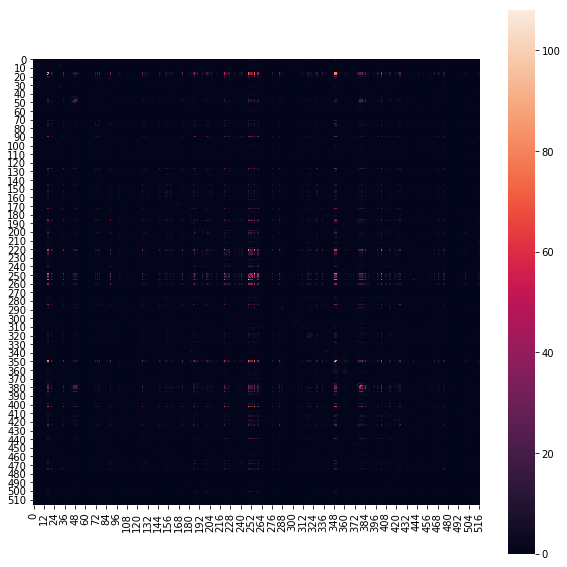

In [25]:
fig,ax = plt.subplots(figsize=(10,10))
sns.heatmap(kegg_pathway_counts.values, square=True)
plt.show()

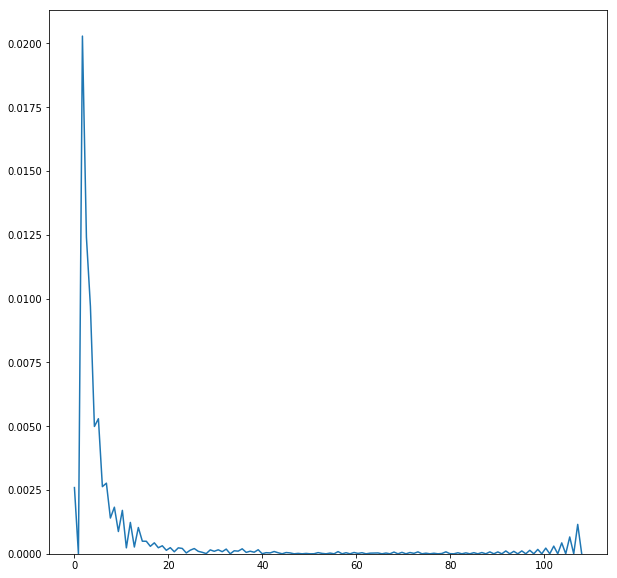

In [26]:
fig, ax = plt.subplots(figsize=(10,10))

__ = sns.kdeplot(kegg_pathway_counts.values.ravel())
plt.show()

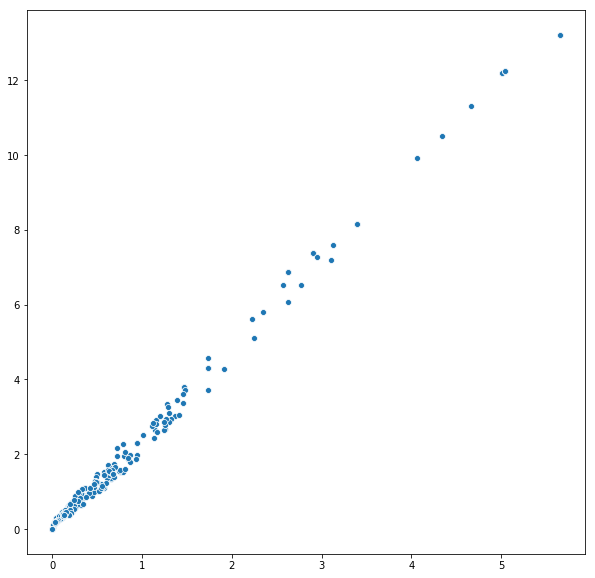

In [27]:
fig, ax = plt.subplots(figsize=(10,10))

mu = np.mean(kegg_pathway_counts.values, axis=0)
s = np.std(kegg_pathway_counts.values, axis=0)

__ = sns.scatterplot(x=mu, y=s)
plt.show()

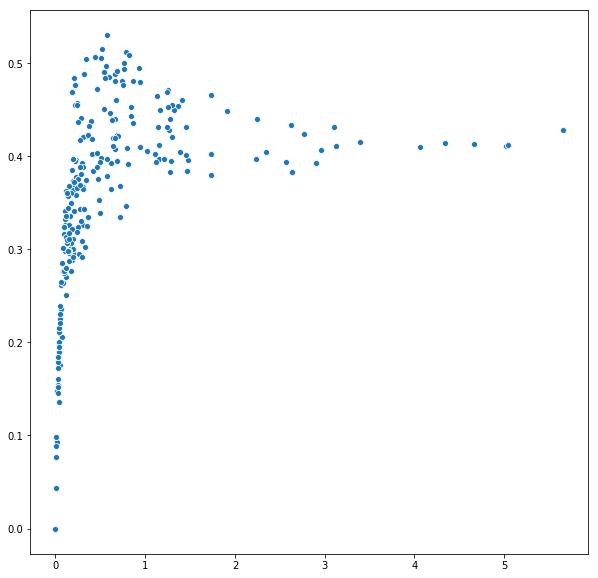

In [28]:
fig, ax = plt.subplots(figsize=(10,10))

mu = np.mean(kegg_pathway_counts.values, axis=0)
s = np.std(kegg_pathway_counts.values, axis=0)
np.place(s, s==0, 1.)

__ = sns.scatterplot(x=mu, y=mu/s)
plt.show()

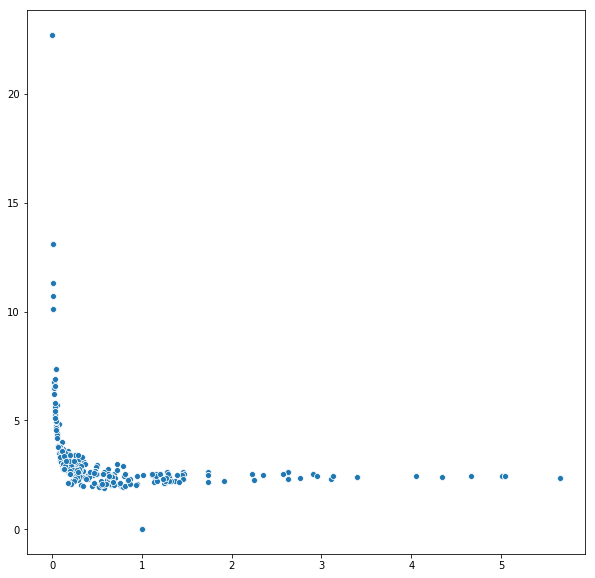

In [29]:
fig, ax = plt.subplots(figsize=(10,10))

mu = np.mean(kegg_pathway_counts.values, axis=0)
s = np.std(kegg_pathway_counts.values, axis=0)
np.place(mu, mu==0, 1.)

__ = sns.scatterplot(x=mu, y=s/mu)
plt.show()

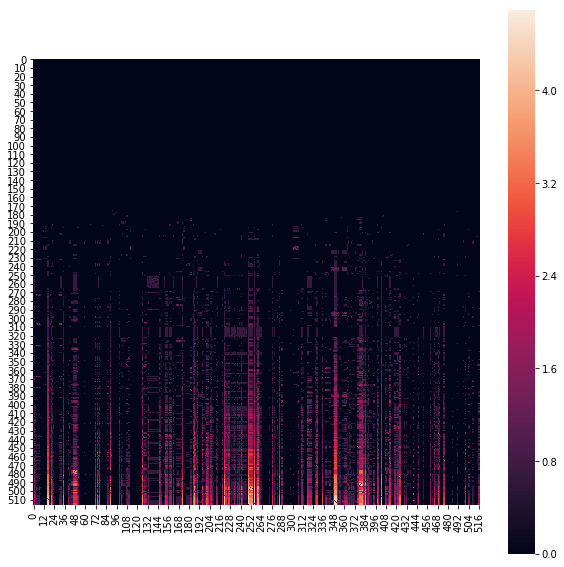

In [30]:
t = copy(kegg_pathway_counts)
t['mean'] = np.mean(t.values, axis=0)
t.sort_values(by='mean', axis=0, inplace=True)
t = t.drop('mean', axis = 1)

fig,ax = plt.subplots(figsize=(10,10))
sns.heatmap(np.log(t.values+1), square=True)
plt.show()

In [31]:
num_kinases_in_kegg = len(set([hgnc_mapper[gen] if gen in hgnc_mapper.keys() and hgnc_mapper[gen] in kin_set else None for path_set in iter(pathway_genes.values()) for gen in path_set]))-1
print(num_kinases_in_kegg)

344


In [107]:
kegg_pathway_counts.to_csv('../data/KEGG/raw_cooccurrence_counts.csv',header=True, sep='\t')

In [33]:
def anscombe(x):
    return 2*np.sqrt(x + .375)

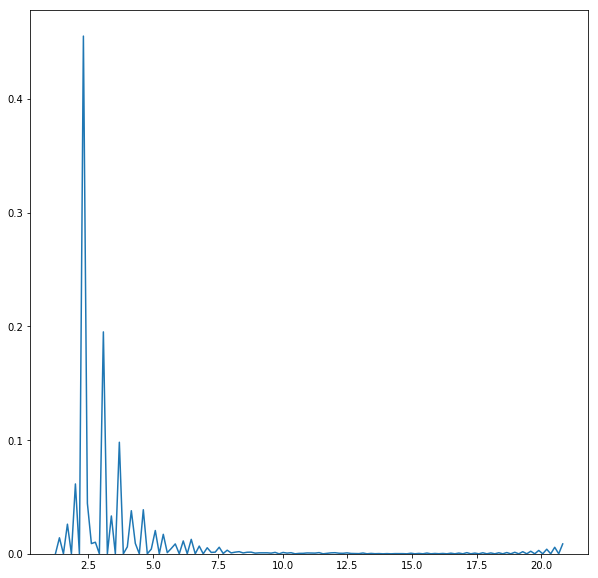

In [34]:
fig, ax = plt.subplots(figsize=(10,10))

__ = sns.kdeplot(np.apply_along_axis(anscombe,axis=0, arr=kegg_pathway_counts.values.ravel()))
plt.show()

In [40]:
kegg_pathway_counts.applymap(anscombe).to_csv('../data/KEGG/anscombe_counts.csv',header=True, sep='\t')

### Alternatives

In [55]:
from scipy.spatial.distance import cdist

In [88]:
def coals(X, keep=None, svd=None):
    '''
    Inputs: 
        X (n x n) - co-occurence dataframe
        keep (None, int) - number of columns to keep (by sum)
        svd (None, int) - number of components to reduce to
    '''
    # select top k if desired
    if keep:
        X = X[X.sum(axis=1).sort_values(ascending=False).index.tolist()].iloc[:, :keep]
    
    # apply correlation
    X = pd.DataFrame(cdist(X.values, X.values, metric='correlation'), columns = X.columns, index=X.index).fillna(1) - 1
    
    # remove negatives
    X[X < 0] = 0
    
    if svd:
        X_new, __, ___= np.linalg.svd(X)
        X = pd.DataFrame(X_new[:, :svd], index = X.index)
    
    return X

In [89]:
coals(kegg_pathway_counts).to_csv('../data/KEGG/coals_counts.csv',header=True, sep='\t')
coals(kegg_pathway_counts.applymap(anscombe)).to_csv('../data/KEGG/both_anscombe_coals_counts.csv',header=True, sep='\t')
coals(kegg_pathway_counts, svd=15).to_csv('../data/KEGG/coals_15_counts.csv',header=True, sep='\t')

### Proceed to weight the network


In [109]:
for f in os.listdir('../data/KEGG/'):
    
    # skip non csv files
    if 'csv' not in f:
        continue
    
    # read in weights
    kegg_weights = pd.read_csv('../data/KEGG/' + f, sep='\t', index_col=0, header=0)
    
    # skip dimension spaces
    if kegg_weights.shape[0] != kegg_weights.shape[1]:
        continue
    
    weights = []
    for kin_0, kin_1 in zip(network['Node1'], network['Node2']):
        weights.append(kegg_weights.loc[kin_0, kin_1])

    print(f.split('_')[0])
    print(np.min(weights))
    print(np.mean(weights))
    print(np.max(weights))
    print()
    
    network[2] = weights
    network.to_csv('../data/interactionNetworks/kin_'+f.split('_')[0]+'_weighted.csv', sep='\t', header=False, index=False)

both
0.0
0.0008556265050266221
0.08747394155542333

anscombe
1.224744871391589
2.986334328674446
20.82066281365701

raw
0.0
3.6158705092775367
108.0

coals
0.0
0.0007867284821987216
0.07959108233174539

